# importing libraries

In [1]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")
import re
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Loading data

In [2]:
cars = pd.read_csv('data_model.csv')

In [3]:
df_cars = cars.copy()  #makinga copy of original data set

print('Original Data Shape:',df_cars.shape)


Original Data Shape: (3813, 41)


# Target KPI
Metric	    Target Range

MAE	          2,000–8,000

RMSE	      3,000–12,000

MAPE	      ≤15% (across all prices)

R² Score	  >0.80, ideally >0.85

# choice of columns

In [4]:
df_cars.columns

Index(['brand', 'model', 'model_year', 'fuel_type', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title', 'price', 'years_used', 'capacity',
       'horsepower', 'cylinder_count', 'mileage_per_year', 'mileage_sqrt',
       'mileage_with_age', 'mileage_per_year_with_age', 'mileage_brand',
       'mileage', 'brand_category', 'log_price', 'power_to_weight_ratio',
       'brand_frequency', 'model_frequency', 'brand_target_enc',
       'model_target_enc', 'mileage_per_year_sqrt', 'mileage_times_age',
       'mileage_sqrt_times_age', 'horsepower_times_cylinder_count',
       'capacity_mileage_interaction', 'age_squared', 'mileage_binned',
       'log_mileage', 'log_capacity', 'capacity_binned', 'horsepower_binned',
       'age_binned', 'trans_num', 'brand_enc'],
      dtype='object')

In [5]:
col1 = ['fuel_type', 'transmission', 'capacity_binned', 'mileage_sqrt', 'years_used', 
        'log_price', 'brand', 'horsepower', 'brand_frequency']
col12 = col1
col = col1

# polynomial features with Ridge regression

In [6]:

# Function to perform polynomial regression with Ridge (regularized) regression
def perform_polynomial_regression_with_regularization(df, target_column, degree, alpha,random_state):
    # Splitting the data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Train-test split (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=True)

    # Scaling the features before polynomial transformation
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize PolynomialFeatures
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    # Generate polynomial features for both training and testing data
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Initialize Ridge Regression model (regularized linear regression)
    model = Ridge(alpha=alpha)

    # Fit the model on the polynomial features
    model.fit(X_train_poly, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test_poly)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Relative Metrics (MAPE and sMAPE)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    smape = np.mean(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100

    # Exponentiate to get the original price scale (since log_price was used)
    y_pred_original = np.exp(y_pred)
    y_test_original = np.exp(y_test)

    # Calculate MAE, MSE, RMSE, and R² for actual prices
    mae_actual = mean_absolute_error(y_test_original, y_pred_original)
    mse_actual = mean_squared_error(y_test_original, y_pred_original)
    rmse_actual = np.sqrt(mse_actual)
    r2_actual = r2_score(y_test_original, y_pred_original)

    # Relative Metrics for actual prices
    mape_actual = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    smape_actual = np.mean(2 * np.abs(y_test_original - y_pred_original) / (np.abs(y_test_original) + np.abs(y_pred_original))) * 100

    # Results
    results = {
        "MAE (Actual Price)": mae_actual,
        "MSE (Actual Price)": mse_actual,
        "RMSE (Actual Price)": rmse_actual,
        "R² Score (Actual Price)": r2_actual,
        "MAPE (mean of absolute percentage error)": mape_actual,
        "sMAPE (same as mape but avoids division by 0)": smape_actual
    }

    return results, y_pred, y_test



In [7]:
df_poly = df_cars[col]
rndm_state=44
# Apply one-hot encoding for categorical columns (if applicable)
categorical_columns = df_poly.select_dtypes(include=['object', 'category']).columns.to_list()
df_poly = pd.get_dummies(df_poly, columns=categorical_columns, drop_first=True)

# Run polynomial regression with Ridge (regularized)
results_poly, y_pred_poly, y_test_poly = perform_polynomial_regression_with_regularization(df_poly, target_column='log_price', degree=2, alpha=1.0, random_state=rndm_state)

# Display the results
for metric, value in results_poly.items():
    print(f"{metric}: {value}")

MAE (Actual Price): 7794.829136281385
MSE (Actual Price): 207880057.79727593
RMSE (Actual Price): 14418.046254512985
R² Score (Actual Price): 0.8542913183775678
MAPE (mean of absolute percentage error): 21.851586521593344
sMAPE (same as mape but avoids division by 0): 21.1473543399652


## Hyperparameter tuning

In [8]:
# Hyperparameter tuning with GridSearchCV
def tune_hyperparameters(X, y):
    # Define the range of hyperparameters to search over
    param_grid = {
        'poly__degree': [2],  # Try different degrees for the polynomial features
        'ridge__alpha': [0.1, 1.0, 10.0,100.0,1000.0]  # Regularization strength
    }

    # Create a Ridge regression model
    ridge_model = Ridge()

    # Create a pipeline for polynomial features and regression
    model_pipeline = Pipeline([
        ('poly', PolynomialFeatures()),  # Polynomial features with varying degree
        ('scaler', StandardScaler()),  # Scaling features before regression
        ('ridge', ridge_model)  # Ridge regression
    ])

    # Use GridSearchCV to search for the best hyperparameters
    grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)

    # Get the best parameters and the best score
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Cross-validation Score:", grid_search.best_score_)

    # Use the best parameters to evaluate the final model
    best_degree = grid_search.best_params_['poly__degree']
    best_alpha = grid_search.best_params_['ridge__alpha']
    
    return best_degree, best_alpha


# Assuming df is your DataFrame with the target column 'log_price'
col1 = ['fuel_type', 'transmission', 'capacity_binned', 'mileage_sqrt', 'years_used', 
        'log_price', 'brand', 'horsepower', 'brand_frequency']
df_poly = df_cars[col1]

# Apply one-hot encoding for categorical columns (if applicable)
categorical_columns = df_poly.select_dtypes(include=['object', 'category']).columns.to_list()
df_poly = pd.get_dummies(df_poly, columns=categorical_columns, drop_first=True)

# Define your features (X) and target (y)
X = df_poly.drop('log_price', axis=1)
y = df_poly['log_price']

# Tune hyperparameters and perform Polynomial Regression with Regularization
best_degree, best_alpha = tune_hyperparameters(X, y)

results_poly_best, y_pred_poly_best, y_test_poly_best = perform_polynomial_regression_with_regularization(df_poly, target_column='log_price', degree=best_degree, alpha=best_alpha,random_state=rndm_state)

# Display the results
for metric, value in results_poly_best.items():
    print(f"{metric}: {value}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...................poly__degree=2, ridge__alpha=0.1; total time=   3.5s
[CV] END ...................poly__degree=2, ridge__alpha=0.1; total time=   3.5s
[CV] END ...................poly__degree=2, ridge__alpha=0.1; total time=   3.8s
[CV] END ...................poly__degree=2, ridge__alpha=0.1; total time=   3.7s
[CV] END ...................poly__degree=2, ridge__alpha=1.0; total time=   3.7s
[CV] END ...................poly__degree=2, ridge__alpha=0.1; total time=   3.7s
[CV] END ...................poly__degree=2, ridge__alpha=1.0; total time=   3.8s
[CV] END ...................poly__degree=2, ridge__alpha=1.0; total time=   3.9s
[CV] END ...................poly__degree=2, ridge__alpha=1.0; total time=   3.2s
[CV] END ...................poly__degree=2, ridge__alpha=1.0; total time=   3.3s
[CV] END ..................poly__degree=2, ridge__alpha=10.0; total time=   3.5s
[CV] END ..................poly__degree=2, ridge_

In [9]:
y_test_poly_best=y_test_poly
y_pred_poly_best=y_pred_poly

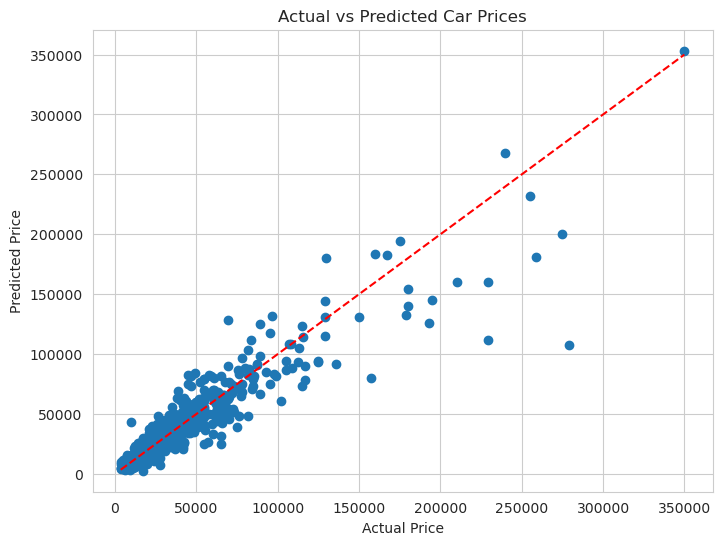

In [10]:
y_pred_original_poly = np.exp(y_pred_poly_best)
y_test_original_poly = np.exp(y_test_poly_best)
residuals_poly = y_test_poly_best - y_pred_poly_best
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original_poly, y_pred_original_poly)
plt.plot([min(y_test_original_poly), max(y_test_original_poly)], [min(y_test_original_poly), max(y_test_original_poly)], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.savefig('LR_poly_price_comparison.png')
plt.show()

In [11]:
mean_residual_poly = np.mean(residuals_poly)
std_residual_poly = np.std(residuals_poly)
outlier_mask_poly = (residuals_poly > mean_residual_poly + 3 * std_residual_poly) | (residuals_poly < mean_residual_poly - 3 * std_residual_poly)

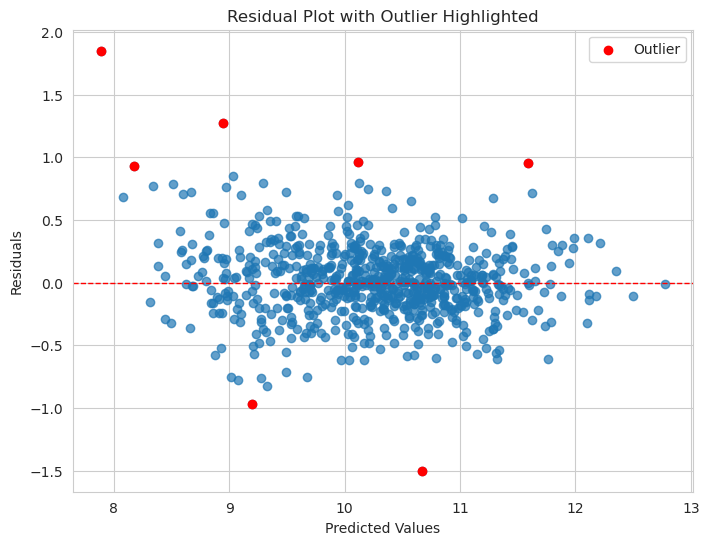

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_poly_best, residuals_poly, alpha=0.7)
plt.scatter(y_pred_poly_best[outlier_mask_poly], residuals_poly[outlier_mask_poly], color='red', label='Outlier')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.title("Residual Plot with Outlier Highlighted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig('LR_poly_residuals.png')
plt.show()

In [13]:
# Remove the outlier
y_test_filtered = y_test_poly_best[~outlier_mask_poly]
y_pred_filtered = y_pred_poly_best[~outlier_mask_poly]

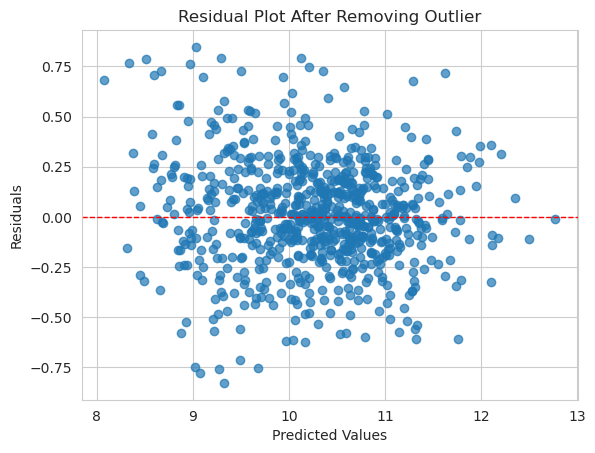

In [14]:
residuals_filtered = y_test_filtered - y_pred_filtered
plt.scatter(y_pred_filtered, residuals_filtered, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot After Removing Outlier")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [15]:
outlier_indices = np.where(outlier_mask_poly)[0]
print("Outlier Indices:", outlier_indices)

Outlier Indices: [150 494 500 515 601 605 762]


In [16]:
# Assuming your dataset is in a DataFrame called df
outlier_data = df_poly.iloc[outlier_indices]
print("Outlier Data Points:")
print(outlier_data)

Outlier Data Points:
     capacity_binned  mileage_sqrt  years_used  log_price  horsepower  \
150              2.0    180.953033         4.0  10.085851  182.000000   
494              4.0    281.675345        11.0   9.729194  445.000000   
500              6.0     80.000000        12.0  10.778977  550.000000   
515              4.0    285.741142        11.0   9.674137  331.515805   
601              4.0    156.831119         3.0  10.553806  331.515805   
605              2.0    194.679223         7.0   9.998843  208.000000   
762              4.0    300.111646         5.0  10.260847  331.515805   

     brand_frequency  fuel_type_Flex Fuel  fuel_type_Gasoline  \
150               64                False                True   
494              367                False                True   
500              373                False                True   
515              130                False                True   
601               56                False                True   
605 

In [17]:
from scipy import stats

# Calculate z-scores
z_scores = stats.zscore(residuals_poly)

# Identify points with z-scores greater than 3 (or less than -3, depending on threshold)
outliers = np.where(np.abs(z_scores) > 3)
print("Outlier indices:", outliers)

Outlier indices: (array([150, 494, 500, 515, 601, 605, 762]),)


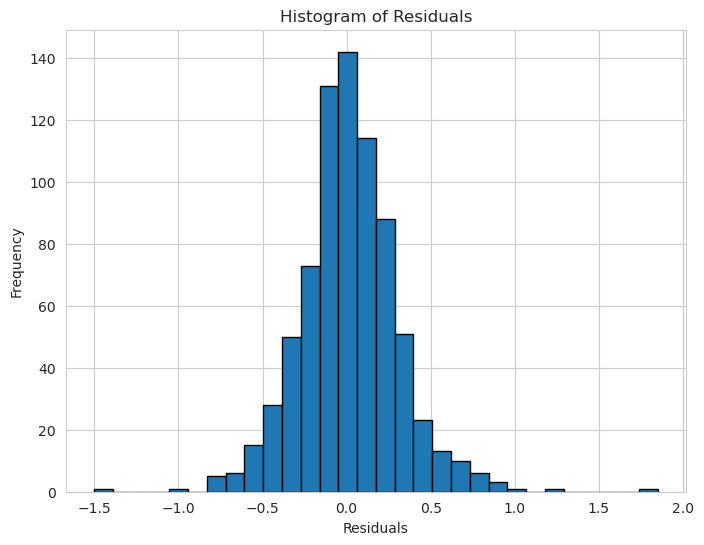

In [21]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals_poly, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.savefig('LR_poly_residual_hist.png')
plt.show()